# Battery RUL Prediction Project

This project aims to predict the Remaining Useful Life (RUL) of batteries based on various voltage, time, and charging-related features. We clean and preprocess the data, remove outliers, and evaluate the effects on different models such as XGBoost, SVR, and Linear Regression.



In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import defaultdict

In [24]:
df = pd.read_csv('data/Battery_RUL.csv')

print(df.shape)
df

(15064, 9)


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
15059,1108.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,1109.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,1110.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,1111.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


##  Assigning Battery IDs

We add a `Battery Index` column to identify individual batteries based on cycle resets. This will help us group and split the dataset by battery.


In [25]:
#adding battery index to the concatenated dataset
battery_idx = list(df[df['Cycle_Index'].diff()< 0]['Cycle_Index'].index)
battery_idx.append(0)
battery_idx.append(len(df))
battery_idx.sort()


for i,j in zip(range(0,len(battery_idx)),range(1,len(battery_idx))):

 
    
    df.loc[battery_idx[i]:battery_idx[j], 'Battery Index' ]= i
    

df = df.drop(columns=['Cycle_Index'])
display(df)
print('There are 14 batteries in this dataset')

,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL,Battery Index
0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112,0.0
1,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111,0.0
2,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110,0.0
3,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109,0.0
4,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107,0.0
...,...,...,...,...,...,...,...,...,...
15059,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4,13.0
15060,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3,13.0
15061,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2,13.0
15062,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1,13.0


There are 14 batteries in this dataset


## Splitting into Train, Validation, and Test Sets
- Training set: Batteries 0–9  
- Validation set: Batteries 10–11  
- Test set: Batteries 12–13  



In [ ]:
df =df[['Battery Index','Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)',
       'RUL']]

train_df = df[df['Battery Index']<=9]
val_df = df[(df['Battery Index']>9)&(df['Battery Index']<=11)]
test_df = df[df['Battery Index']>11]

display(train_df)
display(val_df)
display(test_df)


,Battery Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
0,0.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112
1,0.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111
2,0.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110
3,0.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109
4,0.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107
...,...,...,...,...,...,...,...,...,...
10782,9.0,876.00,234.166667,3.800,3.711,1160.250,1736.25,7280.25,4
10783,9.0,876.00,234.750000,3.800,3.711,1156.375,1700.38,7352.38,3
10784,9.0,876.00,233.470588,3.800,3.711,1155.812,1700.31,7298.06,2
10785,9.0,885.56,229.781250,3.793,3.966,780.500,1463.00,8337.00,1


,Battery Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
10787,10.0,2576.00,1197.024000,3.663,3.223,5418.016000,6712.99,10815.74,1107
10788,10.0,7371.01,1232.000000,4.239,3.234,5460.000000,6712.99,10500.00,1106
10789,10.0,7343.01,1148.000000,4.241,3.240,5439.008000,6692.00,10402.02,1105
10790,10.0,7343.01,1123.504000,4.243,3.241,5446.016000,6699.01,10363.48,1104
10791,10.0,64889.99,1130.511000,4.287,3.247,5439.008000,107552.49,107552.49,1102
...,...,...,...,...,...,...,...,...,...
12936,11.0,1000.62,254.117647,3.783,3.695,1358.375000,2024.38,7607.62,4
12937,11.0,998.06,254.117647,3.783,3.695,1360.884429,2024.31,7586.50,3
12938,11.0,998.38,253.323529,3.783,3.696,1355.803571,1988.38,7594.12,2
12939,11.0,1000.38,247.219000,3.779,3.960,1022.438000,1806.44,8340.12,1


,Battery Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL
12941,12.0,2590.02,1274.016000,3.657,3.230,5355.008,6664.00,10864.00,1113
12942,12.0,7378.01,1326.511500,4.232,3.234,5411.008,6671.01,10576.99,1112
12943,12.0,7356.99,1246.016000,4.235,3.239,5404.000,6656.99,10479.01,1111
12944,12.0,7343.01,1215.679000,4.236,3.240,5404.004,6657.00,10409.00,1110
12945,12.0,64978.47,1221.488000,4.284,3.246,5397.024,107732.31,107732.31,1108
...,...,...,...,...,...,...,...,...,...
15059,13.0,770.44,179.523810,3.773,3.742,922.775,1412.38,6678.88,4
15060,13.0,771.12,179.523810,3.773,3.744,915.512,1412.31,6670.38,3
15061,13.0,769.12,179.357143,3.773,3.742,915.513,1412.31,6637.12,2
15062,13.0,773.88,162.374667,3.763,3.839,539.375,1148.00,7660.62,1


##  Battery Lifetimes

We plot the maximum RUL of each battery to understand variability in lifespan across the dataset.


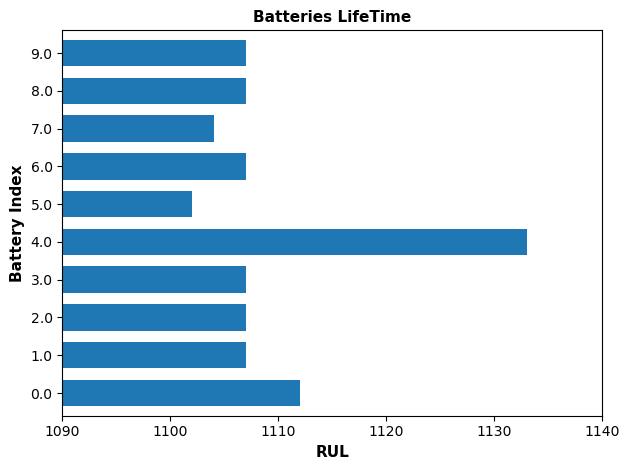

Battery Index
0.0    1112
1.0    1107
2.0    1107
3.0    1107
4.0    1133
5.0    1102
6.0    1107
7.0    1104
8.0    1107
9.0    1107
Name: RUL, dtype: int64


In [27]:
max_rul =train_df.groupby('Battery Index')['RUL'].max()
ax=max_rul.plot(kind='barh',width=0.7, stacked=True,align='center')
plt.title('Batteries LifeTime',fontweight='bold',size=11)
plt.xlabel('RUL',fontweight='bold',size=11)
plt.xticks(size=10)
plt.ylabel('Battery Index',fontweight='bold',size=11)
plt.yticks(size=10)
plt.xlim(1090,1140)
plt.tight_layout()
plt.show()
print(max_rul)

## Correlation Analysis




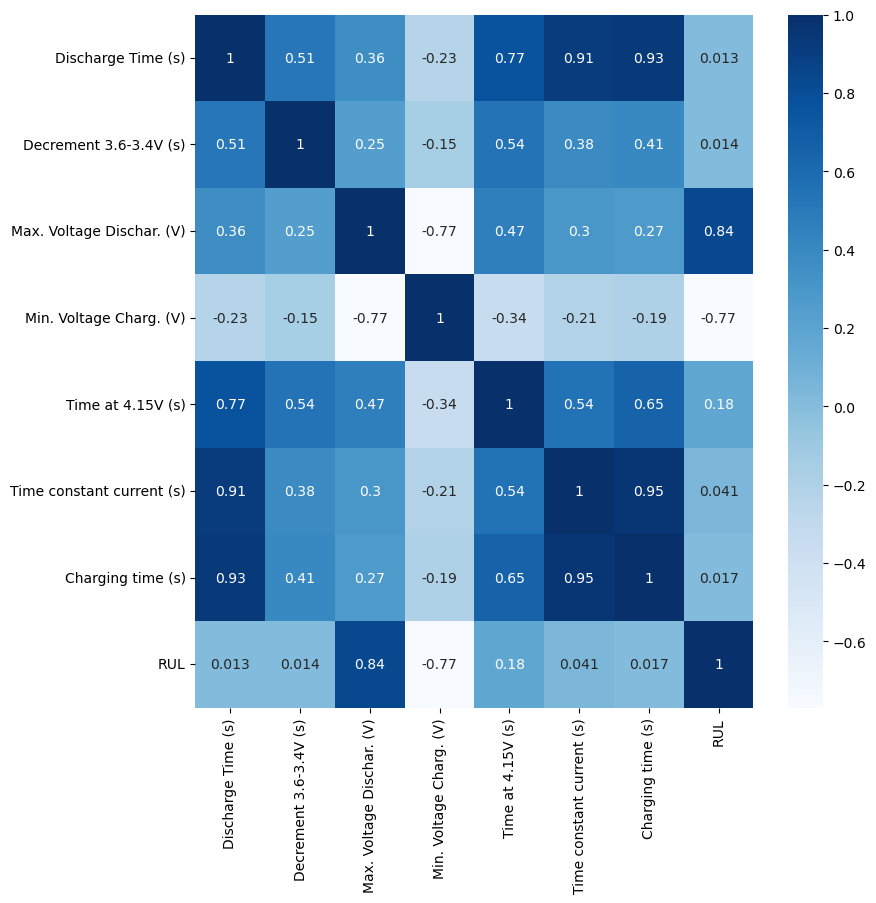

In [28]:
corr_matrix = train_df.drop(columns=['Battery Index']).corr()
sns.heatmap(corr_matrix, cmap="Blues", annot=True)
fig=plt.gcf()
fig.set_size_inches(9,9)
plt.show()


In [29]:
def plot_features(df):
    features = list(df.drop(columns=['RUL','Battery Index']).columns)
    
    plt.figure(figsize=(13,5))
    for i in features:
        for j in df['Battery Index'].unique():
            plt.plot('RUL', i, data = df[df['Battery Index']==j])
        plt.xlim(1133, 0) 
        plt.xticks(np.arange(0, 1133, 100))
        plt.ylabel(i)
        plt.xlabel('Remaining Useful Life')
        plt.show()

In [30]:
# plot_features(train_df)

In [31]:
# plot_features(test_df)

##### As shown from the correlation matrix and the plots, only Max Voltage Discharge, Min Voltage charge and Time at 4.15V had correlation with RUL.

#### Removing Outliers

In [ ]:
# features = list(train_df.drop(columns=['Battery Index', 'RUL']).columns)

# for i in features:
#      sns.boxplot(train_df[i])
#      plt.show()

In [33]:
def outlier_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 =  df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower, upper = Q1 - IQR*1.5, Q3 + IQR*1.5

    df = df[(df[column]>lower) & (df[column]<upper)]

    return lower, upper

In [88]:
features = list(train_df.drop(columns=['Battery Index', 'RUL']).columns)

train_df_clean = train_df.copy()



for i in features:
    lower, upper = outlier_bounds(train_df,i)
    
    train_df_clean = train_df[(train_df[i]>lower) & (train_df[i]<upper)]




## Boxplots After Outlier Removal

We visualise the cleaned training features to confirm that extreme values have been removed.

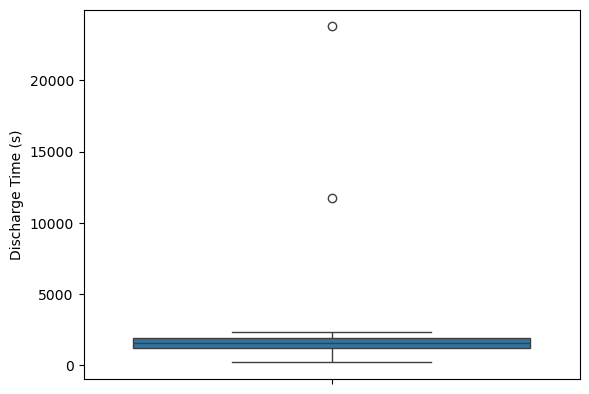

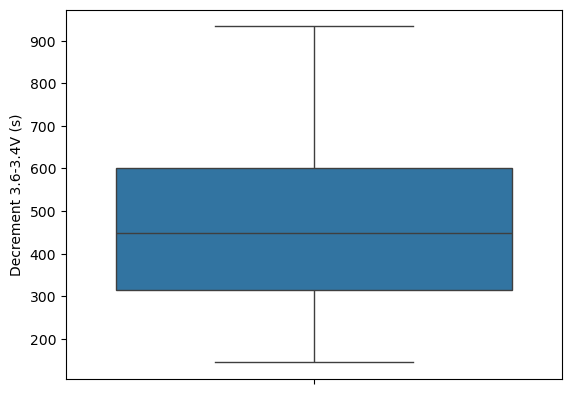

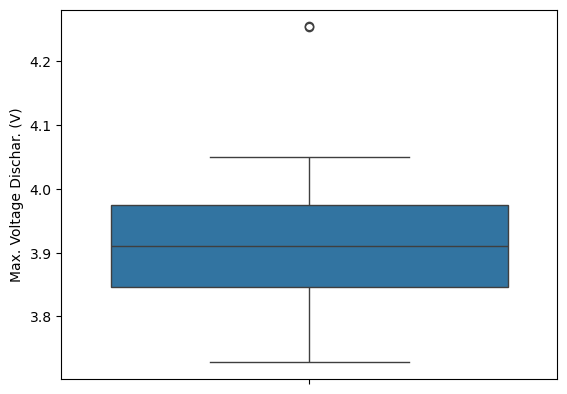

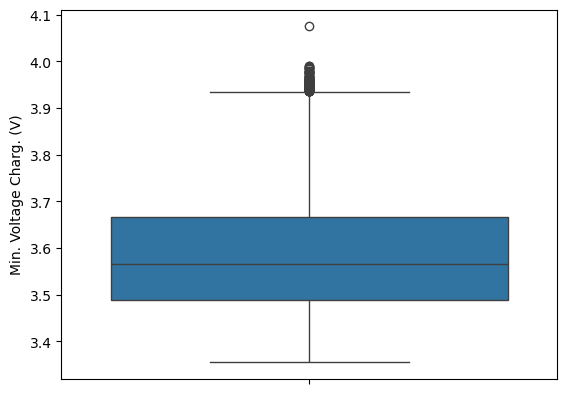

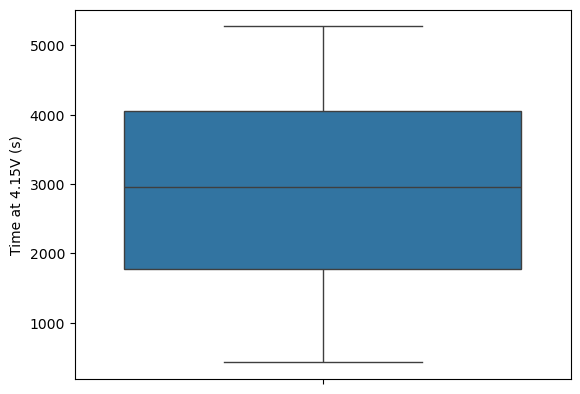

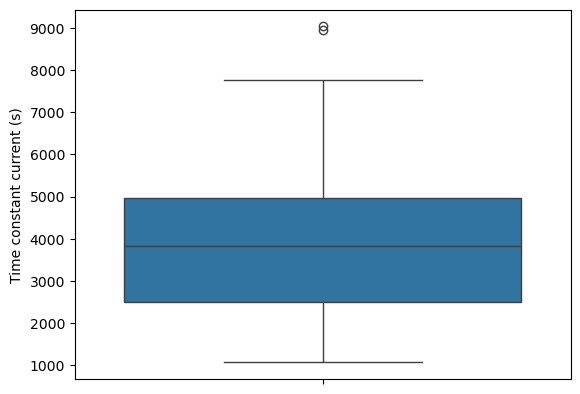

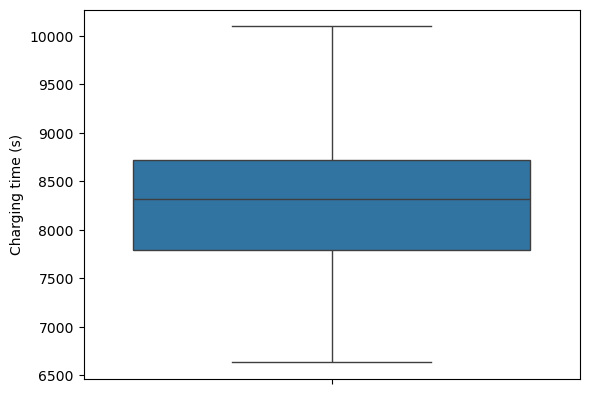

In [35]:
for i in features:
    sns.boxplot(train_df_clean[i])
    plt.show()

## Visualising Features over RUL



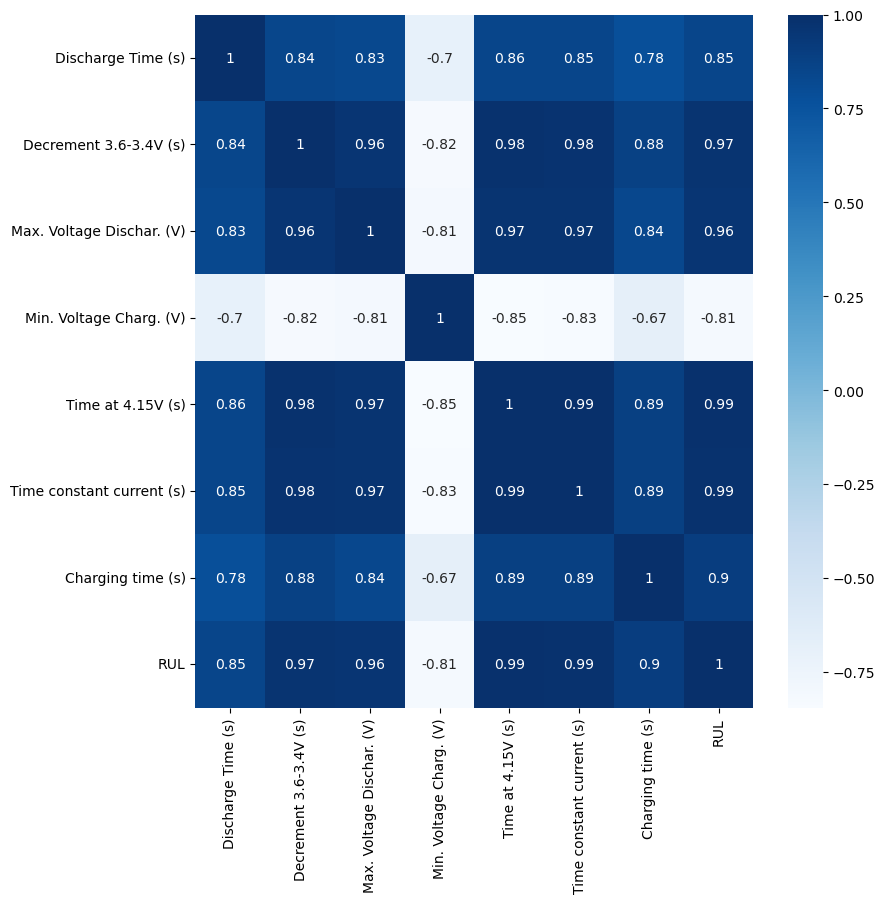

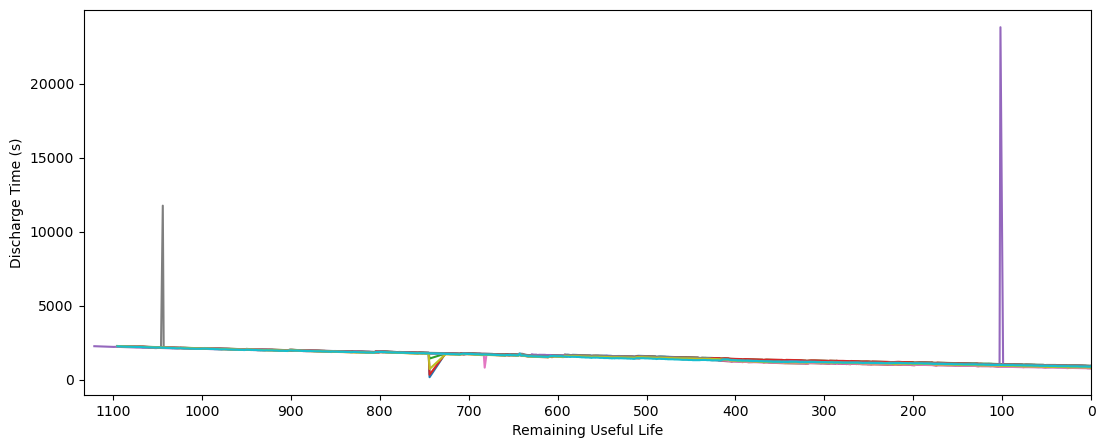

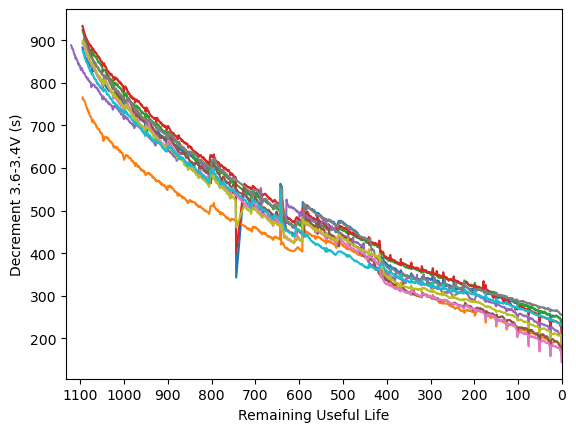

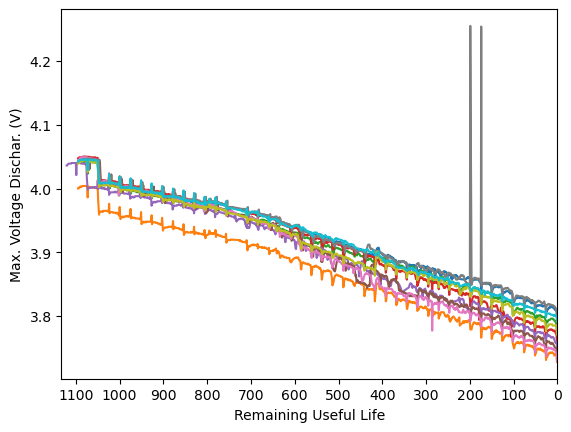

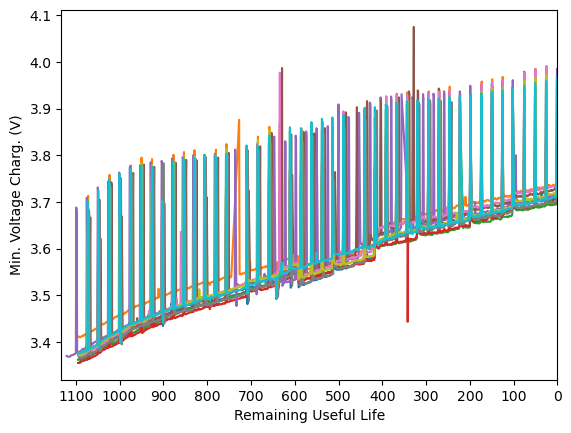

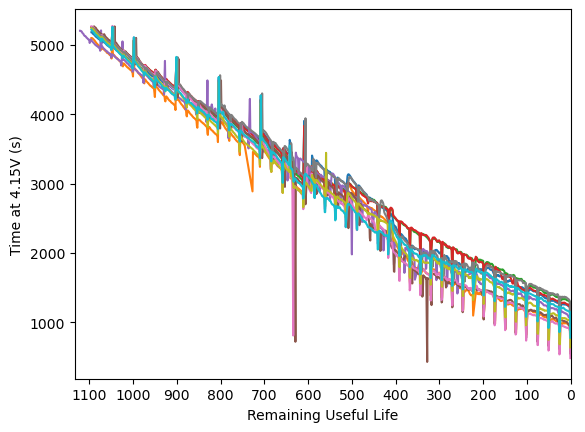

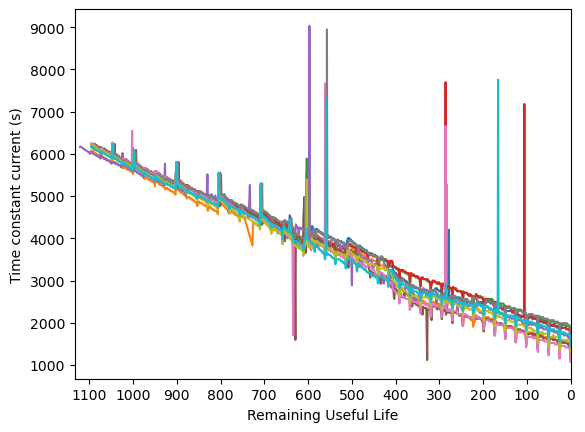

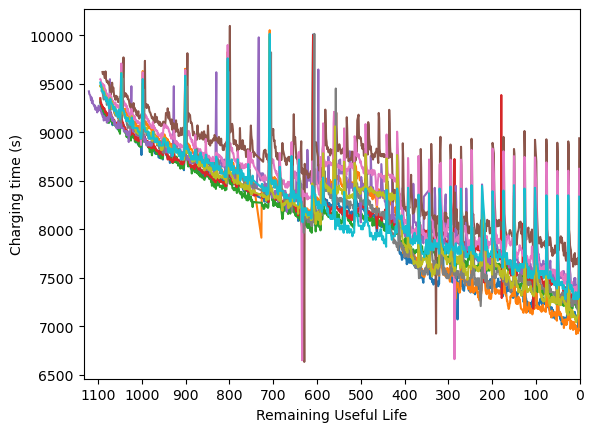

In [89]:
# correlation after outliers removal
corr_matrix = train_df_clean.drop(columns=['Battery Index']).corr()
sns.heatmap(corr_matrix, cmap="Blues", annot=True)
fig=plt.gcf()
fig.set_size_inches(9,9)
plt.show()
plot_features(train_df_clean)

In [37]:
x_train = train_df.drop(columns=['Battery Index', 'RUL'])
y_train = train_df['RUL']

x_val = val_df.drop(columns=['Battery Index', 'RUL'])
y_val = val_df['RUL']

x_test = test_df.drop(columns=['Battery Index', 'RUL'])
y_test = test_df['RUL']


## Feature Scaling

We apply standard scaling to ensure features are on the same scale.  
The scaler is fitted on the training set and applied consistently to the validation and test sets.


In [38]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

### Linear Regression

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

reg = LinearRegression().fit(x_train_scaled, y_train)
y_train_pred = reg.predict(x_train_scaled)

print('Train MAE:', mean_absolute_error(y_train, y_train_pred))
print('Train RMSE:', root_mean_squared_error(y_train, y_train_pred))
print('Train R2:', reg.score(x_train_scaled, y_train))



Train MAE: 75.71033929850034
Train RMSE: 121.03635479101558
Train R2: 0.859186239076073


In [42]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

y_pred = reg.predict(x_val_scaled)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print('MAE:', mae)
print("RMSE:", rmse)
print("R2:", r2)



MAE: 140.47924650024314
RMSE: 197.45976068937094
R2: 0.6235322006137005


In [43]:
result = defaultdict(list)
result['Model'].append('Linear Regression')
result['MAE'].append(mae)
result['RMSE'].append(rmse)
result['R2'].append(r2)

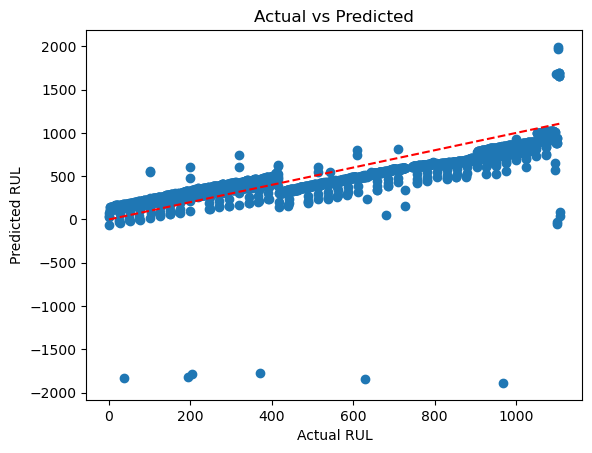

In [44]:
plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted")
plt.show()

### Random Forest Regressor

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold

rf_regressor = RandomForestRegressor(n_jobs= -1, random_state= 0)

param = {'n_estimators':[100,250,500],'max_depth':[None, 10,20], 'min_samples_split':[2, 5,10],'min_samples_leaf': [0.05, 0.1], 'max_features': ['sqrt'] }

group_kfold = GroupKFold(n_splits=5)
groups = train_df['Battery Index']

rf_reg = GridSearchCV(estimator=rf_regressor, param_grid= param, n_jobs=-1, cv = group_kfold , scoring = 'neg_root_mean_squared_error', verbose=1)
rf_reg.fit(x_train_scaled, y_train, groups=groups)
print('Best hyperparameters:', rf_reg.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 10, 'n_estimators': 250}


In [46]:
print('Best hyperparameters:', rf_reg.best_params_)
best_model = rf_reg.best_estimator_

y_train_pred = best_model.predict(x_train_scaled)

print('Train MAE:', mean_absolute_error(y_train, y_train_pred))
print("Train RMSE:",-rf_reg.best_score_)

print("Train R2:",best_model.score(x_train_scaled, y_train))



Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 0.05, 'min_samples_split': 10, 'n_estimators': 250}
Train MAE: 44.67065914086462
Train RMSE: 81.992047626368
Train R2: 0.9414310455205359


In [47]:
y_pred = rf_reg.predict(x_val_scaled)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print('MAE:', mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 62.68671025053071
RMSE: 92.88242664287151
R2: 0.9167013948364751


In [48]:
result['Model'].append('Random Forest Regressor')
result['MAE'].append(mae)
result['RMSE'].append(rmse)
result['R2'].append(r2)

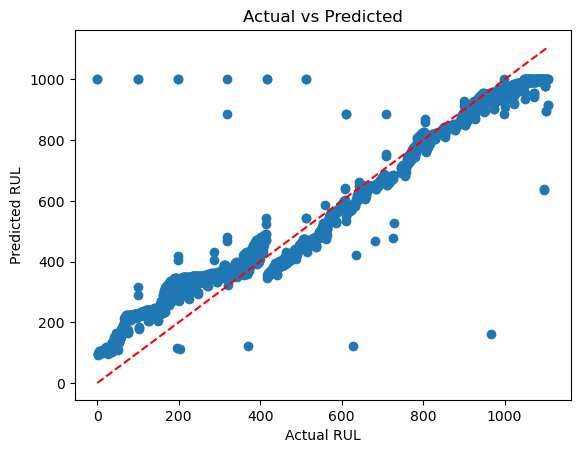

In [49]:
plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted")
plt.show()

### SVR

In [50]:
from sklearn.svm import SVR

svr = SVR(kernel = 'rbf', tol = 1e-3)

param = {'epsilon':[1, 5, 10, 20],'C':[0.1, 1, 10, 100]}

group_kfold = GroupKFold(n_splits=5)
groups = train_df['Battery Index']

svr_grid = GridSearchCV(estimator=svr, param_grid= param, n_jobs=-1, cv = group_kfold , scoring = 'neg_root_mean_squared_error', verbose= 1)
svr_grid.fit(x_train_scaled, y_train, groups=groups)
print('Best hyperparameters:', svr_grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best hyperparameters: {'C': 100, 'epsilon': 1}


In [ ]:
best_model = svr_grid.best_estimator_

y_train_pred = best_model.predict(x_train_scaled)

print('Train MAE:', mean_absolute_error(y_train, y_train_pred))
print("Train RMSE:",-svr_grid.best_score_)
print("Train R2:",best_model.score(x_train_scaled, y_train))

Best hyperparameters: {'C': 100, 'epsilon': 1}
Train MAE: 36.20536832555552
Train RMSE: 63.259625152543336
Train R2: 0.9698079319306363


In [52]:
y_pred = svr_grid.predict(x_val_scaled)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print('MAE:', mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 71.86254325144401
RMSE: 86.35112921713502
R2: 0.9280042823370275


In [53]:
result['Model'].append('SVR')
result['MAE'].append(mae)
result['RMSE'].append(rmse)
result['R2'].append(r2)

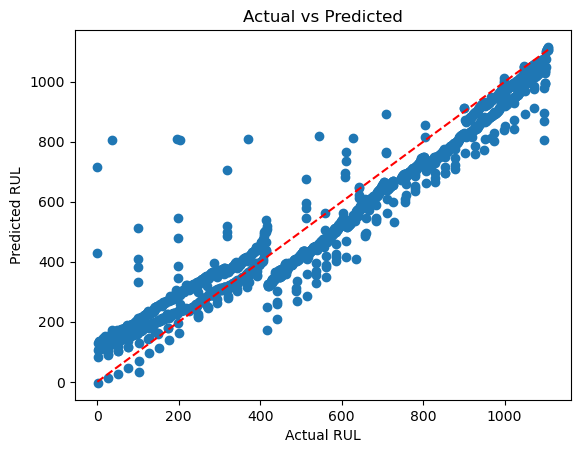

In [54]:
plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted")
plt.show()

#### XGBoost

In [78]:
#https://www.datacamp.com/tutorial/xgboost-in-python
import xgboost as xgb
from xgboost import XGBRegressor
dtrain_reg = xgb.DMatrix(x_train_scaled, y_train, enable_categorical=False, feature_names= features)
dval_reg = xgb.DMatrix(x_val_scaled, y_val, enable_categorical=False, feature_names= features)

In [79]:
n = 3000
params = {
    "objective": "reg:squarederror",
    "device": "cuda",
    "max_depth": 6,
    "eta": 0.05,
    "lambda": 1,   # L2
    "alpha": 0.5     # L1
}
evals = [(dtrain_reg, "train"), (dval_reg, "validation")]

xgb_model  = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   verbose_eval=500,
   evals =evals)
 


[0]	train-rmse:306.70731	validation-rmse:308.15570
[500]	train-rmse:9.57705	validation-rmse:79.86061
[1000]	train-rmse:6.68479	validation-rmse:79.47433
[1500]	train-rmse:5.52622	validation-rmse:79.28871
[2000]	train-rmse:4.89858	validation-rmse:79.34794
[2500]	train-rmse:4.53214	validation-rmse:79.49267
[2999]	train-rmse:4.29568	validation-rmse:79.44736


In [80]:

y_pred = xgb_model.predict(dval_reg)
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
print('MAE:', mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 57.35747337518407
RMSE: 79.44747725557501
R2: 0.939056015423673


In [60]:
result['Model'].append('XGBoost')
result['MAE'].append(mae)
result['RMSE'].append(rmse)
result['R2'].append(r2)

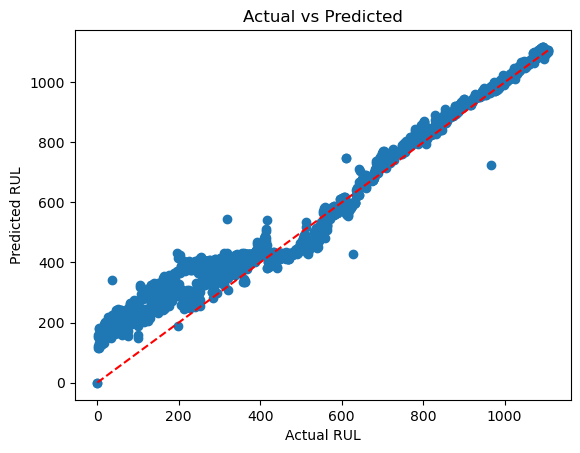

In [81]:
plt.scatter(y_val, y_pred)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted")
plt.show()

In [82]:
results_df = pd.DataFrame(result)
results_df.set_index('Model', inplace=True)
results_df

,MAE,RMSE,R2
Model,,,
Linear Regression,140.479247,197.459761,0.623532
Random Forest Regressor,62.686710,92.882427,0.916701
SVR,71.862543,86.351129,0.928004
XGBoost,57.960259,79.466048,0.939028


XGBoost  outperformed the other models, achieving the lowest validation RMSE and highest R² score across both raw and outlier-cleaned data.

### Performance of XGBoost on Test Set

In [85]:
dtest_reg = xgb.DMatrix(x_test_scaled, y_test, enable_categorical=False, feature_names= features)
y_pred = xgb_model.predict(dtest_reg)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print('MAE:', mae)
print("RMSE:", rmse)
print("R2:", r2)

MAE: 58.32226106820666
RMSE: 78.02216454809704
R2: 0.9414100150163456


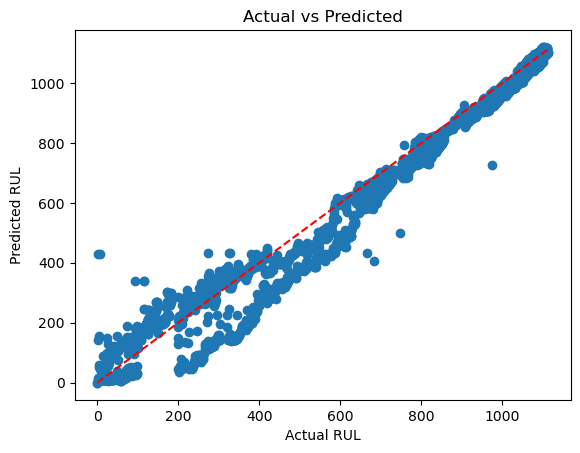

In [86]:
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted")
plt.show()

#### Feature Importance

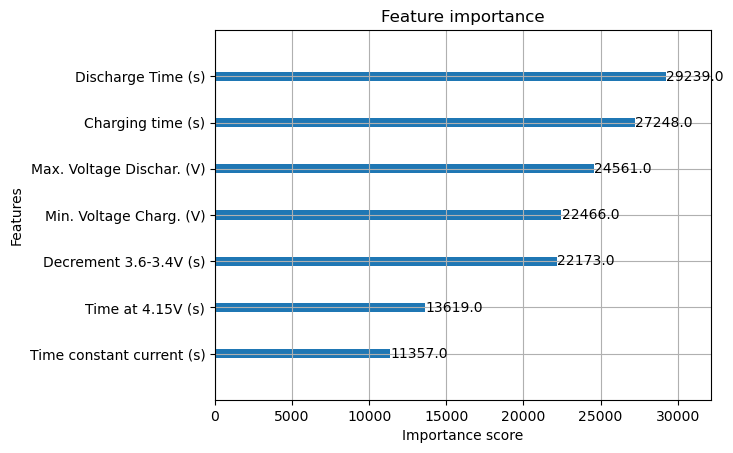

In [87]:
# Get importance scores
importance = xgb_model.get_score(importance_type='weight')  

# Plot it (optional)
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=20)
plt.show()